In [1]:
import os
import shutil
import random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, regularizers, backend as K

In [2]:
# ---------------------------
# PATH & PARAMETER
# ---------------------------
raw_data_dir = "E:\DATASET"
preprocessed_dir = "E:\Preprocessed"
split_data_dir = "E:\Split"
target_size = (224, 224)
batch_size = 32
num_classes = 4
epochs = 100

In [3]:
# ---------------------------
# 1. PREPROCESS (convert ke RGB, resize, normalisasi, save)
# ---------------------------
def preprocess_and_save(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        for class_name in os.listdir(source_dir):
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")  # paksa semua gambar jadi RGB
                    img = img.resize(target_size)

                    # Normalisasi piksel ke [0,1]
                    img_array = np.asarray(img).astype(np.float32) / 255.0

                    # Simpan kembali hasil normalisasi (RGB)
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))
                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"Preprocessing selesai dan disimpan : {dest_dir}")
    else:
        print(f"Preprocessed data sudah ada di: {dest_dir}")

In [4]:
# ---------------------------
# 2. SPLIT DATA (train/val/test)
# ---------------------------
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(os.path.join(dest_dir, 'train')) or not os.listdir(os.path.join(dest_dir, 'train')):
        for class_name in os.listdir(source_dir):
            src_class = os.path.join(source_dir, class_name)
            images = os.listdir(src_class)
            random.shuffle(images)
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            for i, img_name in enumerate(images):
                subset = "train" if i < train_end else "val" if i < val_end else "test"
                dst_path = os.path.join(dest_dir, subset, class_name)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(os.path.join(src_class, img_name), os.path.join(dst_path, img_name))

        print(f"Data telah di-split dan disimpan di: {dest_dir}")
    else:
        print(f"Data sudah ada di folder {dest_dir}, split tidak dilakukan.")

# ---------------------------
# JALANKAN
# ---------------------------
preprocess_and_save(raw_data_dir, preprocessed_dir, target_size=(224, 224))
split_data(preprocessed_dir, split_data_dir)

Preprocessed data sudah ada di: E:\Preprocessed
Data sudah ada di folder E:\Split, split tidak dilakukan.


In [5]:
def check_image_color_modes(image_dirs):
    mode_count = {'RGB': 0, 'Grayscale': 0, 'Other': 0}
    error_files = []

    # Iterate through all directories in the list
    for image_dir in image_dirs:
        print(f"Memeriksa folder: {image_dir}")
        
        # Iterate through all images in the directory
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(root, file)

                    try:
                        # Buka gambar dengan PIL
                        with Image.open(img_path) as pil_img:
                            mode = pil_img.mode

                            if mode == 'RGB':
                                mode_count['RGB'] += 1
                            elif mode == 'L':  # Mode 'L' adalah Grayscale di PIL
                                mode_count['Grayscale'] += 1
                            else:
                                mode_count['Other'] += 1
                    except Exception as e:
                        error_files.append(f"Error loading {file}: {e}")

    # Print the results
    print("\n=== HASIL DETEKSI TIPE GAMBAR ===")
    for mode, count in mode_count.items():
        print(f"{mode}: {count} gambar")

    if error_files:
        print(f"\n❌ Gagal memproses beberapa file:")
        for error in error_files:
            print(f"- {error}")

# Ganti dengan tiga path dataset kamu
image_dirs = [
    "E:\DATASET",  # Contoh direktori, sesuaikan dengan data kamu
    "E:\Preprocessed",
    "E:\Split"
]

# Panggil fungsi untuk memeriksa mode gambar
check_image_color_modes(image_dirs)


Memeriksa folder: E:\DATASET
Memeriksa folder: E:\Preprocessed
Memeriksa folder: E:\Split

=== HASIL DETEKSI TIPE GAMBAR ===
RGB: 24861 gambar
Grayscale: 0 gambar
Other: 0 gambar


In [6]:
def check_normalized_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))  # Sesuai ukuran target
                img_array = np.array(img).astype(np.float32) / 255.0  # Normalisasi sementara

                if not ((img_array >= 0.0).all() and (img_array <= 1.0).all()):
                    print(f"[!] Gambar TIDAK ter-normalisasi: {img_path}")
                    return False
    print("✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)")
    return True

# Ganti dengan direktori val dan test kamu
val_ok = check_normalized_images(os.path.join(split_data_dir, 'val'))
test_ok = check_normalized_images(os.path.join(split_data_dir, 'test'))


✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)
✅ Semua gambar sudah dalam rentang normalisasi (0.0–1.0)


In [7]:
# ---------------------------
# 3. DATA GENERATOR (tanpa rescale)
# ---------------------------

train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator()  # Tidak pakai rescale

train_generator = train_gen.flow_from_directory(
    os.path.join(split_data_dir, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_gen.flow_from_directory(
    os.path.join(split_data_dir, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5800 images belonging to 4 classes.
Found 1241 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [8]:
def conv_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = conv_block(x, 64)
    x = conv_block(x, 64)
    x = conv_block(x, 128, stride=2)
    x = conv_block(x, 128)
    x = conv_block(x, 256, stride=2)
    x = conv_block(x, 256)
    x = conv_block(x, 512, stride=2)
    x = conv_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ---------------------------
# FOCAL LOSS FUNCTION
# ---------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# ---------------------------
# BUILD & COMPILE MODEL
# ---------------------------
model = build_resnet18(input_shape=(224, 224, 3), num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=focal_loss(gamma=2.0, alpha=0.25),
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,455,620 (43.70 MB)

 Trainable params: 11,446,020 (43.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [9]:
# ---------------------------
# 5. CALLBACKS
# ---------------------------
checkpoint = ModelCheckpoint('Model Terbaik_Tahap 1.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_keras = ModelCheckpoint('Model Terbaik_Tahap 1 keras.keras', monitor='val_accuracy', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [10]:
# ---------------------------
# 6. TRAINING
# ---------------------------
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr]
)

C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3208 - loss: 0.6524

182/182 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.3209 - loss: 0.6522 - val_accuracy: 0.3779 - val_loss: 0.5738 - learning_rate: 1.0000e-04
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4226 - loss: 0.5695

182/182 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.4227 - loss: 0.5695 - val_accuracy: 0.5004 - val_loss: 0.5369 - learning_rate: 1.0000e-04
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.4927 - loss: 0.5433 - val_accuracy: 0.4795 - val_loss: 0.5812 - learning_rate: 1.0000e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5762 - loss: 0.5092

182/182 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.5763 - loss: 0.5092 - val_accuracy: 0.6414 - val_loss: 0.4845 - learning_rate: 1.0000e-04
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6502 - loss: 0.4787

182/182 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.6502 - loss: 0.4787 - val_accuracy: 0.6664 - val_loss: 0.4722 - learning_rate: 1.0000e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.6770 - loss: 0.4618 - val_accuracy: 0.5818 - val_loss: 0.5179 - learning_rate: 1.0000e-04
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6980 - loss: 0.4435

182/182 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.6980 - loss: 0.4435 - val_accuracy: 0.7083 - val_loss: 0.4415 - learning_rate: 1.0000e-04
Epoch 8/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.7136 - loss: 0.4286 - val_accuracy: 0.4746 - val_loss: 0.5210 - learning_rate: 1.0000e-04
Epoch 9/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7220 - loss: 0.4165

182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7220 - loss: 0.4165 - val_accuracy: 0.7687 - val_loss: 0.3989 - learning_rate: 1.0000e-04
Epoch 10/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7342 - loss: 0.4027 - val_accuracy: 0.7373 - val_loss: 0.3938 - learning_rate: 1.0000e-04
Epoch 11/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.7488 - loss: 0.3859 - val_accuracy: 0.6124 - val_loss: 0.4262 - learning_rate: 1.0000e-04
Epoch 12/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7671 - loss: 0.3680

182/182 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7671 - loss: 0.3680 - val_accuracy: 0.7897 - val_loss: 0.3519 - learning_rate: 1.0000e-04
Epoch 13/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7684 - loss: 0.3569 - val_accuracy: 0.7180 - val_loss: 0.3618 - learning_rate: 1.0000e-04
Epoch 14/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7683 - loss: 0.3451 - val_accuracy: 0.7059 - val_loss: 0.3538 - learning_rate: 1.0000e-04
Epoch 15/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7764 - loss: 0.3326 - val_accuracy: 0.7607 - val_loss: 0.3259 - learning_rate: 1.0000e-04
Epoch 16/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7932 - loss: 0.3157 - val_accuracy: 0.6269 - val_loss: 0.3566 - learning_rate: 1.0000e-04
Epoch 17/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8012 - loss: 0.3070

182/182 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8012 - loss: 0.3070 - val_accuracy: 0.8131 - val_loss: 0.3004 - learning_rate: 1.0000e-04
Epoch 18/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7943 - loss: 0.2963 - val_accuracy: 0.7438 - val_loss: 0.3140 - learning_rate: 1.0000e-04
Epoch 19/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8126 - loss: 0.2830 - val_accuracy: 0.6970 - val_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 20/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8006 - loss: 0.2784 - val_accuracy: 0.7905 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 21/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8028 - loss: 0.2666 - val_accuracy: 0.7462 - val_loss: 0.2768 - learning_rate: 1.0000e-04
Epoch 22/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8193 - loss: 0.2560

182/182 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.8192 - loss: 0.2560 - val_accuracy: 0.8364 - val_loss: 0.2441 - learning_rate: 1.0000e-04
Epoch 23/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.8099 - loss: 0.2466 - val_accuracy: 0.7961 - val_loss: 0.2477 - learning_rate: 1.0000e-04
Epoch 24/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.8004 - loss: 0.2413 - val_accuracy: 0.8058 - val_loss: 0.2400 - learning_rate: 1.0000e-04
Epoch 25/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8196 - loss: 0.2319 - val_accuracy: 0.5890 - val_loss: 0.3022 - learning_rate: 1.0000e-04
Epoch 26/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8192 - loss: 0.2224 - val_accuracy: 0.5165 - val_loss: 0.3419 - learning_rate: 1.0000e-04
Epoch 27/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.8257 - loss: 0.2165 - val_accuracy: 0.7808 - val_loss: 0.2321 - learning_rate: 1.0000e-04
Epoch 28/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8424 - loss: 0.1809 - val_accuracy: 0.8493 - val_loss: 0.1840 - learning_rate: 1.0000e-04
Epoch 34/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8369 - loss: 0.1762 - val_accuracy: 0.5761 - val_loss: 0.3522 - learning_rate: 1.0000e-04
Epoch 35/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.8418 - loss: 0.1731 - val_accuracy: 0.8171 - val_loss: 0.1844 - learning_rate: 1.0000e-04
Epoch 36/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8394 - loss: 0.1697 - val_accuracy: 0.8453 - val_loss: 0.1647 - learning_rate: 1.0000e-04
Epoch 37/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8430 - loss: 0.1650 - val_accuracy: 0.7397 - val_loss: 0.2140 - learning_rate: 1.0000e-04
Epoch 38/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8428 - loss: 0.1602 - val_accuracy: 0.8195 - val_loss: 0.1700 - learning_rate: 1.0000e-04
Epoch 39/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8696 - loss: 0.1326 - val_accuracy: 0.8662 - val_loss: 0.1401 - learning_rate: 1.0000e-04
Epoch 48/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8632 - loss: 0.1337 - val_accuracy: 0.7784 - val_loss: 0.1733 - learning_rate: 1.0000e-04
Epoch 49/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8588 - loss: 0.1319 - val_accuracy: 0.8574 - val_loss: 0.1339 - learning_rate: 1.0000e-04
Epoch 50/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8793 - loss: 0.1242 - val_accuracy: 0.7712 - val_loss: 0.1653 - learning_rate: 1.0000e-04
Epoch 51/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8505 - loss: 0.1292 - val_accuracy: 0.7857 - val_loss: 0.1710 - learning_rate: 1.0000e-04
Epoch 52/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.8582 - loss: 0.1287 - val_accuracy: 0.7985 - val_loss: 0.1458 - learning_rate: 1.0000e-04
Epoch 53/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8826 - loss: 0.1031 - val_accuracy: 0.8670 - val_loss: 0.1151 - learning_rate: 1.0000e-04
Epoch 68/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8957 - loss: 0.0995 - val_accuracy: 0.8082 - val_loss: 0.1320 - learning_rate: 1.0000e-04
Epoch 69/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.8832 - loss: 0.1030 - val_accuracy: 0.8010 - val_loss: 0.1322 - learning_rate: 1.0000e-04
Epoch 70/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8819 - loss: 0.0982 - val_accuracy: 0.8380 - val_loss: 0.1240 - learning_rate: 1.0000e-04
Epoch 71/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.8791 - loss: 0.0998 - val_accuracy: 0.6519 - val_loss: 0.2276 - learning_rate: 1.0000e-04
Epoch 72/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8869 - loss: 0.0967 - val_accuracy: 0.7736 - val_loss: 0.1500 - learning_rate: 1.0000e-04
Epoch 73/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9157 - loss: 0.0873 - val_accuracy: 0.8759 - val_loss: 0.1083 - learning_rate: 5.0000e-05
Epoch 75/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9273 - loss: 0.0838

182/182 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9273 - loss: 0.0838 - val_accuracy: 0.8815 - val_loss: 0.1112 - learning_rate: 5.0000e-05
Epoch 76/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9163 - loss: 0.0851 - val_accuracy: 0.8396 - val_loss: 0.1252 - learning_rate: 5.0000e-05
Epoch 77/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9204 - loss: 0.0836

182/182 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9204 - loss: 0.0836 - val_accuracy: 0.8912 - val_loss: 0.1039 - learning_rate: 5.0000e-05
Epoch 78/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9176 - loss: 0.0836 - val_accuracy: 0.8453 - val_loss: 0.1316 - learning_rate: 5.0000e-05
Epoch 79/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9168 - loss: 0.0836 - val_accuracy: 0.8751 - val_loss: 0.1084 - learning_rate: 5.0000e-05
Epoch 80/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9210 - loss: 0.0804 - val_accuracy: 0.8695 - val_loss: 0.1120 - learning_rate: 5.0000e-05
Epoch 81/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9259 - loss: 0.0784 - val_accuracy: 0.8533 - val_loss: 0.1171 - learning_rate: 5.0000e-05
Epoch 82/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9190 - loss: 0.0805 - val_accuracy: 0.8574 - val_loss: 0.1144 - learning_rate: 5.0000e-05
Epoch 83/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accu

182/182 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9346 - loss: 0.0749 - val_accuracy: 0.8936 - val_loss: 0.0980 - learning_rate: 2.5000e-05
Epoch 84/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9419 - loss: 0.0733 - val_accuracy: 0.8791 - val_loss: 0.1109 - learning_rate: 2.5000e-05
Epoch 85/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9427 - loss: 0.0753 - val_accuracy: 0.8824 - val_loss: 0.1024 - learning_rate: 2.5000e-05
Epoch 86/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9363 - loss: 0.0727 - val_accuracy: 0.8888 - val_loss: 0.1062 - learning_rate: 2.5000e-05
Epoch 87/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9470 - loss: 0.0714 - val_accuracy: 0.8936 - val_loss: 0.1007 - learning_rate: 2.5000e-05
Epoch 88/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9437 - loss: 0.0706 - val_accuracy: 0.8880 - val_loss: 0.1037 - learning_rate: 2.5000e-05
Epoch 89/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - ac

182/182 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9541 - loss: 0.0679 - val_accuracy: 0.8977 - val_loss: 0.1035 - learning_rate: 1.2500e-05
Epoch 91/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.9554 - loss: 0.0679 - val_accuracy: 0.8977 - val_loss: 0.1054 - learning_rate: 1.2500e-05
Epoch 92/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9580 - loss: 0.0678 - val_accuracy: 0.8912 - val_loss: 0.1056 - learning_rate: 1.2500e-05
Epoch 93/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9495 - loss: 0.0681 - val_accuracy: 0.8928 - val_loss: 0.1026 - learning_rate: 1.2500e-05
Epoch 94/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9599 - loss: 0.0666

182/182 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9599 - loss: 0.0666 - val_accuracy: 0.9001 - val_loss: 0.1036 - learning_rate: 6.2500e-06
Epoch 95/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9656 - loss: 0.0644

182/182 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9656 - loss: 0.0644 - val_accuracy: 0.9073 - val_loss: 0.1043 - learning_rate: 6.2500e-06
Epoch 96/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9593 - loss: 0.0663 - val_accuracy: 0.9009 - val_loss: 0.1055 - learning_rate: 6.2500e-06
Epoch 97/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9639 - loss: 0.0649 - val_accuracy: 0.8952 - val_loss: 0.1075 - learning_rate: 6.2500e-06
Epoch 98/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9661 - loss: 0.0650 - val_accuracy: 0.8912 - val_loss: 0.1056 - learning_rate: 6.2500e-06
Epoch 99/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9638 - loss: 0.0640 - val_accuracy: 0.8920 - val_loss: 0.1070 - learning_rate: 3.1250e-06
Epoch 100/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9623 - loss: 0.0650 - val_accuracy: 0.8912 - val_loss: 0.1062 - learning_rate: 3.1250e-06


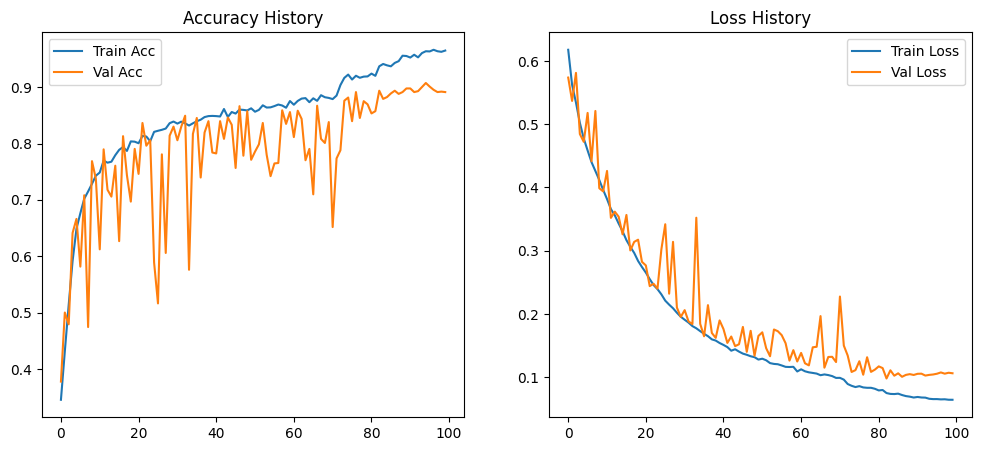

In [11]:
# ---------------------------
# 7. PLOT TRAINING
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 438ms/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.94      0.94      0.94       301
  Kaukasoid-Indic       0.82      0.86      0.84       333
Malayan-Mongoloid       0.85      0.81      0.83       304
       Melanesoid       0.92      0.91      0.91       308

         accuracy                           0.88      1246
        macro avg       0.88      0.88      0.88      1246
     weighted avg       0.88      0.88      0.88      1246



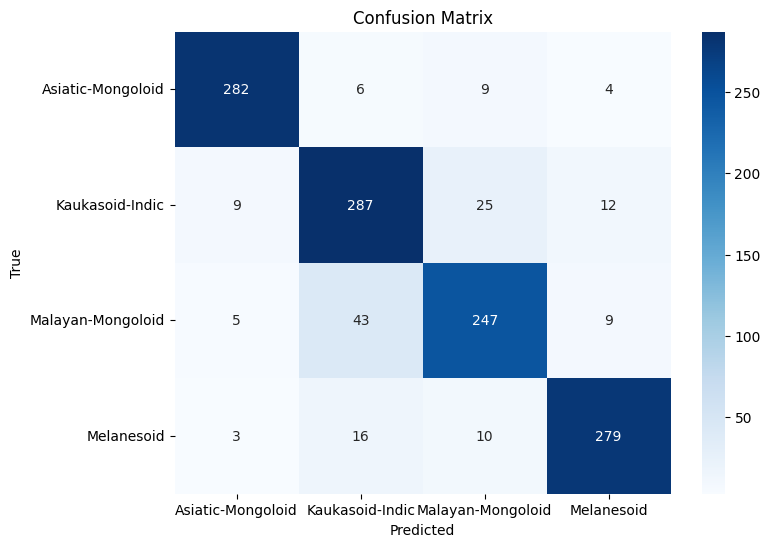

In [12]:
# ---------------------------
# 8. EVALUASI MODEL
# ---------------------------
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step
Classification Report:
                   precision    recall  f1-score   support

Asiatic-Mongoloid       0.95      0.96      0.95       301
  Kaukasoid-Indic       0.83      0.86      0.84       333
Malayan-Mongoloid       0.83      0.84      0.83       304
       Melanesoid       0.95      0.89      0.92       308

         accuracy                           0.89      1246
        macro avg       0.89      0.89      0.89      1246
     weighted avg       0.89      0.89      0.89      1246



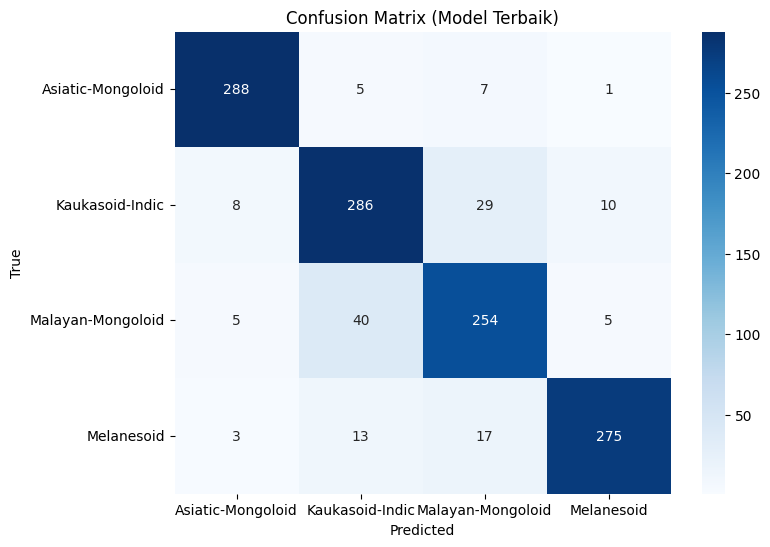

In [13]:
from tensorflow.keras.models import load_model

best_model = load_model(r"E:\Model Terbaik_Tahap 1.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})


# 2. Prediksi pakai model terbaik
y_true = test_generator.classes
y_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

# 3. Buat label
labels = list(test_generator.class_indices.keys())

# 4. Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Model Terbaik)")
plt.show()


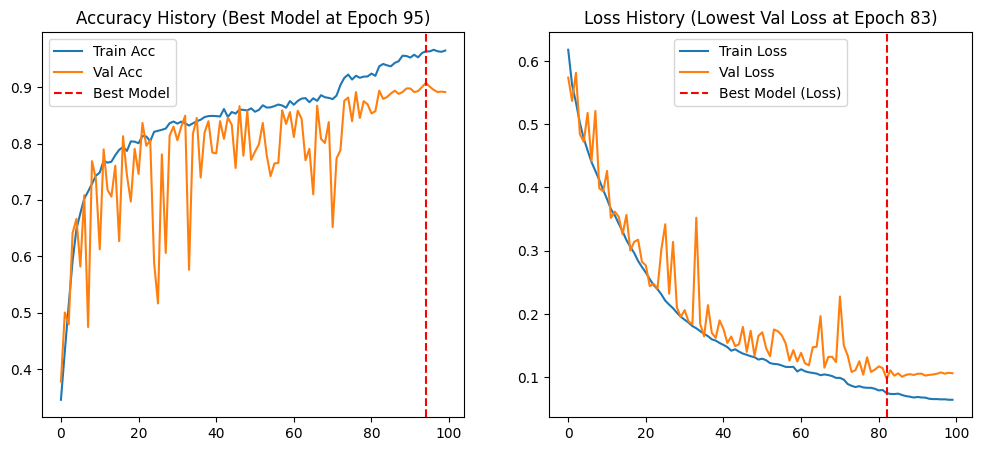

In [14]:
# ---------------------------
# 7. PLOT TRAINING (MODEL TERBAIK)
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='--', label='Best Model')
plt.legend()
plt.title('Accuracy History (Best Model at Epoch {})'.format(np.argmax(history.history['val_accuracy']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(x=np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Model (Loss)')
plt.legend()
plt.title('Loss History (Lowest Val Loss at Epoch {})'.format(np.argmin(history.history['val_loss']) + 1))

plt.show()


In [28]:
#Tahap 2

In [15]:
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
# ============================
# 1. PATH & PARAMETER
# ============================
pretrained_model_path = r"E:\best_resnet18_tahap1.h5"
new_data_dir = r"E:\Penelitian\Dataset Tahap 2"
preprocessed_new_dir = r"E:\Penelitian\Preprocessed_TAHAP2"
split_new_dir = r"E:\Penelitian\Split_TAHAP2"

batch_size = 32
target_size = (224, 224)
epochs = 100
num_classes = 4

In [48]:
# ============================
# PREPROCESSING
# ============================
def preprocess_and_save(source_dir, dest_dir, target_size=(224, 224)):
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

        if not class_folders:
            print("❌ Folder dataset tidak memiliki subfolder kelas. Pastikan struktur dataset benar.")
            return

        for class_name in class_folders:
            src_path = os.path.join(source_dir, class_name)
            dst_path = os.path.join(dest_dir, class_name)
            os.makedirs(dst_path, exist_ok=True)

            for img_name in os.listdir(src_path):
                img_path = os.path.join(src_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(target_size)

                    img_array = np.asarray(img).astype(np.float32) / 255.0
                    save_img = Image.fromarray((img_array * 255).astype(np.uint8))

                    save_path = os.path.join(dst_path, img_name)
                    save_img.save(save_path)
                except Exception as e:
                    print(f"Gagal memproses {img_path}: {e}")

        print(f"✅ Preprocessing selesai dan disimpan di: {dest_dir}")
    else:
        print(f"✅ Preprocessed data sudah ada di: {dest_dir}")

In [49]:
# ============================
# SPLIT DATA
# ============================
from PIL import Image

def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    train_dir = os.path.join(dest_dir, 'train')
    if not os.path.exists(train_dir) or not os.listdir(train_dir):
        class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

        for class_name in class_folders:
            src_class = os.path.join(source_dir, class_name)
            images = [f for f in os.listdir(src_class) if os.path.isfile(os.path.join(src_class, f))]
            random.shuffle(images)
            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            for i, img_name in enumerate(images):
                subset = "train" if i < train_end else "val" if i < val_end else "test"
                dst_path = os.path.join(dest_dir, subset, class_name)
                os.makedirs(dst_path, exist_ok=True)
                shutil.copy(os.path.join(src_class, img_name), os.path.join(dst_path, img_name))

        print(f"✅ Data telah di-split dan disimpan di: {dest_dir}")
    else:
        print(f"✅ Data sudah ada di folder {dest_dir}, split tidak dilakukan.")

# ============================
# JALANKAN
# ============================
preprocess_and_save(new_data_dir, preprocessed_new_dir, target_size=target_size)
split_data(preprocessed_new_dir, split_new_dir)

✅ Preprocessed data sudah ada di: E:\Penelitian\Preprocessed_TAHAP2
✅ Data sudah ada di folder E:\Penelitian\Split_TAHAP2, split tidak dilakukan.


In [50]:
# ============================
# 4. DATA GENERATOR TAHAP 2
# ============================
train_gen_tahap2 = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
val_test_gen_tahap2 = ImageDataGenerator()

train_generator_tahap2 = train_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)
val_generator_tahap2 = val_test_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)
test_generator_tahap2 = val_test_gen_tahap2.flow_from_directory(
    os.path.join(split_new_dir, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 366 images belonging to 4 classes.
Found 74 images belonging to 4 classes.
Found 85 images belonging to 4 classes.


In [51]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras import backend as K
import os

# ============================  
# FOCAL LOSS MANUAL  
# ============================  
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss_tahap2(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Hindari nilai prediksi yang terlalu mendekati 0 atau 1
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        
        # Cross entropy loss
        cross_entropy = -y_true * K.log(y_pred)
        
        # Focal loss: menambah penalti untuk kelas yang lebih sulit
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        
        # Return the sum or mean loss (bisa disesuaikan)
        return K.sum(loss, axis=1)  # Bisa ganti dengan K.mean() jika mau rata-rata
    return focal_loss_fixed



# ============================  
# 5. LOAD MODEL & FINE-TUNING  
# ============================  

# Load model tahap 1 (ResNet18 dari tahap 1)
best_model = load_model(r"E:\Model Terbaik_Tahap 1.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})

# Unfreeze sebagian besar layer untuk fine-tuning
total_layers = len(best_model.layers)
unfreeze_from = total_layers // 2  # Unfreeze mulai dari layer setengah terakhir

# Freeze layer yang lebih awal
for i, layer in enumerate(best_model.layers):
    layer.trainable = i >= unfreeze_from

# Gunakan layer terakhir yang eksplisit untuk layer dense baru
last_layer_output = best_model.get_layer(index=-2).output  # Bisa juga pakai nama layer jika tahu
x = Dense(256, activation='relu')(last_layer_output)  # Layer tambahan untuk fine-tuning
x = Dense(4, activation='softmax')(x)  # Output layer (misal 4 kelas, sesuaikan dengan num_classes)
fine_tune_model = Model(inputs=best_model.input, outputs=x)

# Compile model dengan focal loss
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss=focal_loss(gamma=2.0, alpha=0.25),
                        metrics=['accuracy'])

# Ringkasan model untuk memeriksa layer-layer
fine_tune_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,585,924 (44.20 MB)

 Trainable params: 10,892,292 (41.55 MB)

 Non-trainable params: 693,632 (2.65 MB)

In [52]:
# --------------------------- 
# 5. CALLBACKS TAHAP 2
# ---------------------------
checkpoint_tahap2 = ModelCheckpoint('Model_Terbaik_Tahap_2.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_keras_tahap2 = ModelCheckpoint('Model_Terbaik_Tahap_2_keras.keras', monitor='val_accuracy', save_best_only=True)

reduce_lr_tahap2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [53]:
# ============================
# 6. TRAINING FINE-TUNE MODEL
# ============================
history = fine_tune_model.fit(
    train_generator_tahap2,  # Menggunakan generator untuk tahap 2
    epochs=epochs,  # Pastikan kamu sudah mendefinisikan 'epochs'
    validation_data=val_generator_tahap2,  # Menggunakan validation generator untuk tahap 2
    callbacks=[checkpoint_tahap2, reduce_lr_tahap2]  # Pastikan kamu sudah mendefinisikan 'checkpoint' dan 'reduce_lr'
)


C:\Users\rayna\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.2907 - loss: 0.2789

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2904 - loss: 0.2774 - val_accuracy: 0.4054 - val_loss: 0.2635 - learning_rate: 1.0000e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.3996 - loss: 0.2106

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4000 - loss: 0.2107 - val_accuracy: 0.4189 - val_loss: 0.2873 - learning_rate: 1.0000e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.4234 - loss: 0.1958

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4240 - loss: 0.1952 - val_accuracy: 0.4324 - val_loss: 0.3734 - learning_rate: 1.0000e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.5127 - loss: 0.1688

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5137 - loss: 0.1686 - val_accuracy: 0.4730 - val_loss: 0.2245 - learning_rate: 1.0000e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.4944 - loss: 0.1512

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4958 - loss: 0.1513 - val_accuracy: 0.5676 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5540 - loss: 0.1448 - val_accuracy: 0.5676 - val_loss: 0.1998 - learning_rate: 1.0000e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6379 - loss: 0.1356 - val_accuracy: 0.5676 - val_loss: 0.1886 - learning_rate: 1.0000e-04
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.7038 - loss: 0.1202

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7007 - loss: 0.1203 - val_accuracy: 0.5946 - val_loss: 0.1592 - learning_rate: 1.0000e-04
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6525 - loss: 0.1187 - val_accuracy: 0.5270 - val_loss: 0.1879 - learning_rate: 1.0000e-04
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5854 - loss: 0.1395 - val_accuracy: 0.3784 - val_loss: 0.3743 - learning_rate: 1.0000e-04
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6837 - loss: 0.1171 - val_accuracy: 0.3378 - val_loss: 0.5997 - learning_rate: 1.0000e-04
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6268 - loss: 0.1211 - val_accuracy: 0.5676 - val_loss: 0.2610 - learning_rate: 1.0000e-04
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.7247 - loss: 0.1073

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7215 - loss: 0.1078 - val_accuracy: 0.6486 - val_loss: 0.1833 - learning_rate: 1.0000e-04
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7017 - loss: 0.1043 - val_accuracy: 0.6486 - val_loss: 0.1799 - learning_rate: 5.0000e-05
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7936 - loss: 0.0960 - val_accuracy: 0.5541 - val_loss: 0.1612 - learning_rate: 5.0000e-05
Epoch 16/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7365 - loss: 0.0986 - val_accuracy: 0.6216 - val_loss: 0.1289 - learning_rate: 5.0000e-05
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8105 - loss: 0.0857 - val_accuracy: 0.6486 - val_loss: 0.1238 - learning_rate: 5.0000e-05
Epoch 18/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7543 - loss: 0.0917

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7524 - loss: 0.0922 - val_accuracy: 0.7027 - val_loss: 0.1149 - learning_rate: 5.0000e-05
Epoch 19/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.7775 - loss: 0.0882

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7774 - loss: 0.0881 - val_accuracy: 0.7432 - val_loss: 0.1087 - learning_rate: 5.0000e-05
Epoch 20/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7761 - loss: 0.0827 - val_accuracy: 0.7297 - val_loss: 0.1212 - learning_rate: 5.0000e-05
Epoch 21/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7636 - loss: 0.0796 - val_accuracy: 0.6757 - val_loss: 0.1345 - learning_rate: 5.0000e-05
Epoch 22/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7504 - loss: 0.0819 - val_accuracy: 0.6622 - val_loss: 0.1436 - learning_rate: 5.0000e-05
Epoch 23/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8188 - loss: 0.0740 - val_accuracy: 0.6081 - val_loss: 0.1640 - learning_rate: 5.0000e-05
Epoch 24/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7963 - loss: 0.0793 - val_accuracy: 0.7162 - val_loss: 0.1279 - learning_rate: 5.0000e-05
Epoch 25/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8421 - loss

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8415 - loss: 0.0599 - val_accuracy: 0.7703 - val_loss: 0.1177 - learning_rate: 3.1250e-06
Epoch 44/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8260 - loss: 0.0670 - val_accuracy: 0.7703 - val_loss: 0.1169 - learning_rate: 3.1250e-06
Epoch 45/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8762 - loss: 0.0678 - val_accuracy: 0.7703 - val_loss: 0.1153 - learning_rate: 1.5625e-06
Epoch 46/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8355 - loss: 0.0647 - val_accuracy: 0.7432 - val_loss: 0.1129 - learning_rate: 1.5625e-06
Epoch 47/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8640 - loss: 0.0633 - val_accuracy: 0.7703 - val_loss: 0.1125 - learning_rate: 1.5625e-06
Epoch 48/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.8364 - loss: 0.0622

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8376 - loss: 0.0619 - val_accuracy: 0.7838 - val_loss: 0.1131 - learning_rate: 1.5625e-06
Epoch 49/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8411 - loss: 0.0679 - val_accuracy: 0.7838 - val_loss: 0.1125 - learning_rate: 1.5625e-06
Epoch 50/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8170 - loss: 0.0777 - val_accuracy: 0.7838 - val_loss: 0.1123 - learning_rate: 7.8125e-07
Epoch 51/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8539 - loss: 0.0619 - val_accuracy: 0.7838 - val_loss: 0.1122 - learning_rate: 7.8125e-07
Epoch 52/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8831 - loss: 0.0581 - val_accuracy: 0.7703 - val_loss: 0.1120 - learning_rate: 7.8125e-07
Epoch 53/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8442 - loss: 0.0631 - val_accuracy: 0.7703 - val_loss: 0.1119 - learning_rate: 7.8125e-07
Epoch 54/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8377 - loss

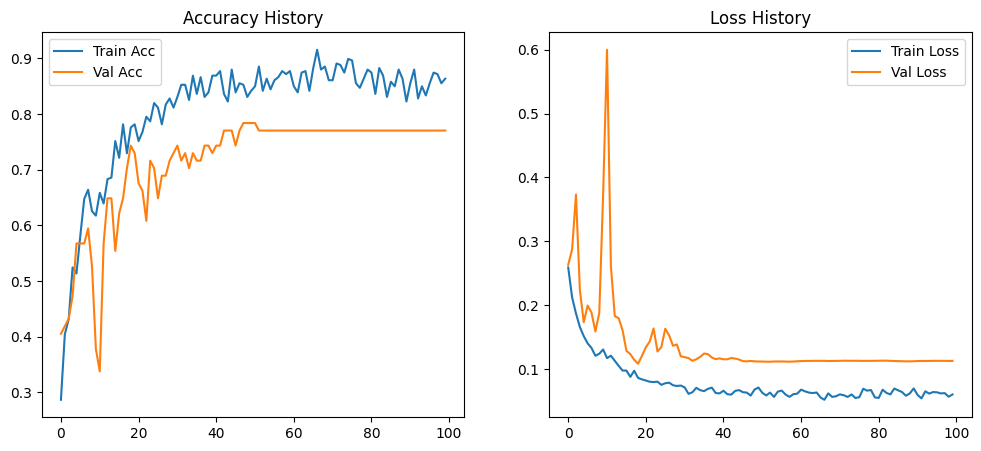

In [54]:
# ============================
# 7. PLOT HISTORY
# ============================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
Jumlah y_true: 85
Jumlah y_pred: 85
Classification Report:
                   precision    recall  f1-score   support

  Asian_Mongoloid       0.67      0.60      0.63        20
  Kaukasoid-Indic       0.59      0.50      0.54        20
Malayan_Mongoloid       0.67      0.75      0.71        24
       Melanesoid       0.87      0.95      0.91        21

         accuracy                           0.71        85
        macro avg       0.70      0.70      0.70        85
     weighted avg       0.70      0.71      0.70        85



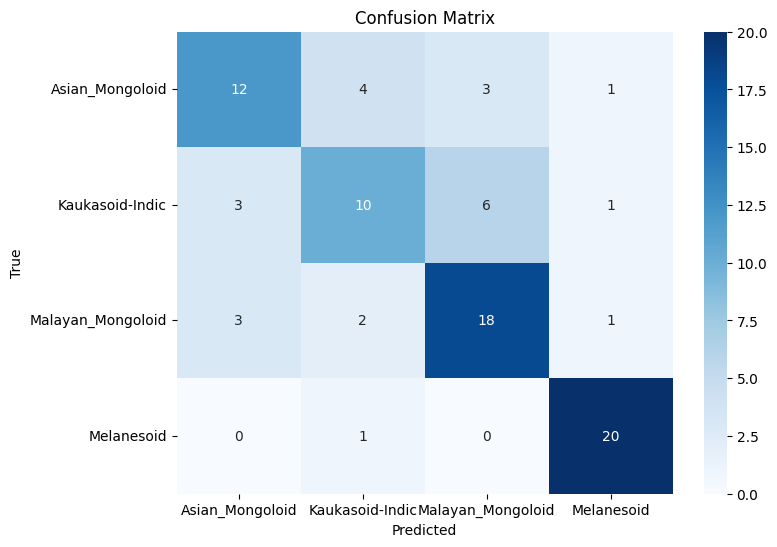

In [57]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Langkah 1: Prediksi
y_pred_probs = fine_tune_model.predict(test_generator_tahap2)
y_pred = np.argmax(y_pred_probs, axis=1)

# Langkah 2: Label sebenarnya
y_true = test_generator_tahap2.classes  # Label ground-truth

# Debug: cek panjang
print(f"Jumlah y_true: {len(y_true)}")
print(f"Jumlah y_pred: {len(y_pred)}")

# Langkah 3: Nama label (jika mau pakai)
labels = list(test_generator_tahap2.class_indices.keys())

# Langkah 4: Classification report & Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
